In [1]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import sentencepiece as spm

from tqdm import tqdm
import random

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device name: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("CUDA is not available. PyTorch will use the CPU.")
    device = 'cpu'

CUDA is available!
CUDA device count: 1
Current CUDA device name: NVIDIA A100-SXM4-40GB


In [5]:
file = "processed_noisy_fibonacci_mixed_5to8_1M_seed_-100_100.csv"
data = pd.read_csv(file).dropna(ignore_index=True)

# Prepare text for sentencepiece
with open("fibonacci_data.txt", "w") as f:
    for idx, row in tqdm(data.iterrows(), total=len(data)):
        line = f"{row['context']},{row['target']}"
        f.write(line + "\n")

vocab_size = 2000
spm.SentencePieceTrainer.train(
    input='fibonacci_data.txt',
    model_prefix='fibonacci',
    vocab_size=vocab_size,
    model_type='unigram',
    character_coverage=1.0,
    user_defined_symbols=[',', '-']
)

tok = spm.SentencePieceProcessor(model_file='fibonacci.model')

train_size = 0.8
train_df = data.sample(frac=train_size, random_state=42).reset_index(drop=True)
test_df = data.drop(train_df.index).reset_index(drop=True)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

100%|██████████| 1000000/1000000 [00:37<00:00, 26476.58it/s]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: fibonacci_data.txt
  input_format: 
  model_prefix: fibonacci
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: ,
  user_defined_symbols: -
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk

Train size: 800000, Test size: 200000


cabs: fibonacci.vocab


In [6]:
def get_fibonacci_sequences(df, tokenizer):
    seqs_x = []
    seqs_y = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        text = f"{row['context']},{row['target']}"
        ids = tokenizer.encode(text, out_type=int)
        
        if len(ids) < 2:
            continue
            
        x = ids[:-1]
        y = ids[1:]
        
        seqs_x.append(x)
        seqs_y.append(y)
    return seqs_x, seqs_y

train_seqs_x, train_seqs_y = get_fibonacci_sequences(train_df, tok)
test_seqs_x, test_seqs_y = get_fibonacci_sequences(test_df, tok)

100%|██████████| 200000/200000 [00:11<00:00, 17474.50it/s]


In [7]:
class TokenDatasetB(Dataset):
    def __init__(self, seqs_x, seqs_y):
        self.seqs_x = seqs_x
        self.seqs_y = seqs_y
    
    def __len__(self):
        return len(self.seqs_x)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.seqs_x[idx]), torch.LongTensor(self.seqs_y[idx])

# Padding collate function for variable length sequences
def collate_fnB(batch):
    seqs_x, seqs_y = zip(*batch)
    lens = [len(s) for s in seqs_x]
    max_len = max(lens)
    
    # Pad sequences
    padded_x = torch.zeros(len(seqs_x), max_len, dtype=torch.long)
    padded_y = torch.zeros(len(seqs_y), max_len, dtype=torch.long)
    
    for i, (x, y) in enumerate(zip(seqs_x, seqs_y)):
        padded_x[i, :len(x)] = x
        padded_y[i, :len(y)] = y
    
    return padded_x, padded_y, torch.LongTensor(lens)

dataset = TokenDatasetB(train_seqs_x, train_seqs_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fnB)

In [8]:
for batch_idx, (x, y, lengths) in enumerate(train_loader):
    print("bi")
    print(batch_idx)
    print("x")
    print(x)
    print(x.shape)
    print("y")
    print(y)
    print(y.shape)
    print("lengths")
    print(lengths.shape)
    break

lengths[:10]

bi
0
x
tensor([[  6,  18,   3,  36,   3,  69,   3,  84,   3,   5,  49,   3, 169,   3,
           9,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  6,  88,   3,  18,   3,   5,   7,   5,   3,   5,  40,   3, 171,   3,
           9,  16,   3,  57,  12,   3,   5, 107,   3,   5,  66,   0,   0,   0,
           0,   0,   0],
        [  6,   4,  21,   3,   4,   5,  12,   3,   4,  51,   3,   4,  47,   3,
           4,  80,   3,   4,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [ 98,   3,   4,  86,   3,   4,  76,   3,   4,   5,  64,   3,   4, 138,
           3,   4,   9,  33,   3,   4,  55,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  6,   4,  53,   3,  18,   3,   4,  19,   3,   9,   3,   4,  16,   3,
           4,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  6,   4,  63,   3,  37,   3,   5,  13,   3,  54,   3, 108,   3,   5,

tensor([16, 25, 19, 21, 16, 16, 22, 20, 15, 28])

In [9]:
class GPTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )

        self.ln2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, causal_mask, padding_mask):
        # Self-attention (GPT-style)
        h = self.ln1(x)
        attn_out, _ = self.attn(
            h, h, h,
            attn_mask=causal_mask,
            key_padding_mask=padding_mask,
            need_weights=False
        )
        x = x + attn_out

        # Feedforward
        h = self.ln2(x)
        ff_out = self.mlp(h)
        x = x + ff_out

        return x
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=1024,
                 embed_dim=512, num_heads=4,
                 num_layers=4, mlp_dim=1024, dropout=0.2):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos = nn.Embedding(max_len, embed_dim)

        self.layers = nn.ModuleList([
            GPTBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])

        self.ln_final = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
        self.head.weight = self.embed.weight  # weight tying

    def causal_mask(self, T, device):
        mask = torch.triu(torch.ones(T, T, device=device), 1)
        return mask.masked_fill(mask == 1, float('-inf'))

    def forward(self, x, lengths=None):
        B, T = x.shape
        device = x.device

        tok = self.embed(x)
        pos = self.pos(torch.arange(T, device=device)[None, :])
        h = tok + pos

        causal = self.causal_mask(T, device)     # (T, T)
        pad_mask = (x == 0)                      # (B, T)

        for layer in self.layers:
            h = layer(h, causal, pad_mask)

        h = self.ln_final(h)
        return self.head(h)                      # (B, T, V)


In [10]:
# LSTM Model
class LSTMNextToken(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_out, _ = self.lstm(packed)
        
        # Unpack
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        output = self.dropout(output)
        logits = self.fc(output)
        
        return logits

In [11]:
# Training function
def train_model(model, train_loader, epochs=10, lr=1e-4, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    track_loss = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        loader = tqdm(train_loader)
        
        for x, y, lengths in loader:
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(x, lengths)
            
            # Reshape for loss calculation
            logits = logits.view(-1, logits.size(-1))
            y = y.view(-1)
            
            loss = criterion(logits, y)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            track_loss.append(loss.item())
            avg_loss = sum(track_loss[-10:]) / 10
            loader.set_postfix(loss=avg_loss)
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    return model




In [12]:
dataset = TokenDatasetB(train_seqs_x, train_seqs_y)
train_loader = DataLoader(dataset, batch_size=4096, shuffle=True, collate_fn=collate_fnB)

# Initialize model (set vocab_size to your tokenizer's vocab size + special tokens)
vocab_size = tok.get_piece_size()

# Using smaller model for this task as it's simpler than language 
# model = DecoderOnlyTransformer(vocab_size=vocab_size, max_len=1024, embed_dim=256, num_heads=4, num_layers=6, mlp_dim=1024, dropout=0.1)
model = LSTMNextToken(
    vocab_size=tok.get_piece_size(),
    embed_dim=256,   # Matches Transformer
    hidden_dim=512,  # Increased to match parameter count
    num_layers=2,    # Tuned to match parameter count
    dropout=0.1      # Matching Transformer dropout
)

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 5216208


In [15]:
# Train
model = train_model(model, train_loader, epochs=15, lr=1e-4)


100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=2.07]


Epoch 1/15, Average Loss: 2.2523


100%|██████████| 196/196 [01:11<00:00,  2.75it/s, loss=1.8] 


Epoch 2/15, Average Loss: 1.9121


100%|██████████| 196/196 [01:11<00:00,  2.75it/s, loss=1.65]


Epoch 3/15, Average Loss: 1.7189


100%|██████████| 196/196 [01:02<00:00,  3.14it/s, loss=1.55]


Epoch 4/15, Average Loss: 1.5973


100%|██████████| 196/196 [01:03<00:00,  3.09it/s, loss=1.49]


Epoch 5/15, Average Loss: 1.5219


100%|██████████| 196/196 [00:58<00:00,  3.36it/s, loss=1.44]


Epoch 6/15, Average Loss: 1.4615


100%|██████████| 196/196 [00:49<00:00,  3.96it/s, loss=1.39]


Epoch 7/15, Average Loss: 1.4125


100%|██████████| 196/196 [00:48<00:00,  4.01it/s, loss=1.36]


Epoch 8/15, Average Loss: 1.3730


100%|██████████| 196/196 [00:48<00:00,  4.08it/s, loss=1.32]


Epoch 9/15, Average Loss: 1.3370


100%|██████████| 196/196 [00:49<00:00,  3.97it/s, loss=1.3] 


Epoch 10/15, Average Loss: 1.3099


100%|██████████| 196/196 [01:01<00:00,  3.21it/s, loss=1.28]


Epoch 11/15, Average Loss: 1.2860


100%|██████████| 196/196 [01:01<00:00,  3.17it/s, loss=1.26]


Epoch 12/15, Average Loss: 1.2647


100%|██████████| 196/196 [01:02<00:00,  3.15it/s, loss=1.23]


Epoch 13/15, Average Loss: 1.2452


100%|██████████| 196/196 [00:52<00:00,  3.73it/s, loss=1.22]


Epoch 14/15, Average Loss: 1.2279


100%|██████████| 196/196 [00:50<00:00,  3.85it/s, loss=1.2] 

Epoch 15/15, Average Loss: 1.2112


In [41]:
# load in lstm
model = LSTMNextToken(
    vocab_size=tok.get_piece_size(),
    embed_dim=256,   # Matches Transformer
    hidden_dim=512,  # Increased to match parameter count
    num_layers=2,    # Tuned to match parameter count
    dropout=0.1      # Matching Transformer dropout
)
model.load_state_dict(torch.load("fib_lstm_mixed_5M.pth"))
model.eval()
model.to(device)

LSTMNextToken(
  (embedding): Embedding(2000, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=512, out_features=2000, bias=True)
)

In [42]:
# Adapted Generation Function for LSTM
def generate_sequence_lstm(model, tokenizer, start_text, max_new_tokens=10, device='cuda'):
    model.eval()
    ids = tokenizer.encode(start_text, out_type=int)
    x = torch.LongTensor([ids]).to(device)
    
    for _ in range(max_new_tokens):
        # Calculate current length
        current_len = torch.LongTensor([x.size(1)])
        
        with torch.no_grad():
            # PASS LENGTHS TO LSTM
            logits = model(x, current_len)
            next_token = torch.argmax(logits[0, -1, :]).item()
            x = torch.cat([x, torch.LongTensor([[next_token]]).to(device)], dim=1)
            
    full_seq = tokenizer.decode(x[0].tolist())
    return full_seq

print("Sample Generation:")
sample_row = test_df.iloc[0]
prompt = f"{sample_row['context']},"
print("Prompt:", prompt)
print("Gen:", generate_sequence_lstm(model, tok, prompt, device=device))

Sample Generation:
Prompt: -60,-21,-83,-105,-189,-293,
Gen: -60,-21,-83,-105,-189,-293,-482,-778,-1


In [43]:
# Adapted MSE Evaluation for LSTM
def evaluate_icl_mse_lstm(model, tokenizer, test_df, shots_list=[0, 1, 3, 5, 8], num_samples=200, device='cuda'):
    model.eval()
    results = {}
    print(f"\nEvaluating LSTM ICL MSE on {num_samples} samples...")
    
    for k in shots_list:
        mse_list = []
        valid_count = 0
        
        for _ in tqdm(range(num_samples), desc=f"{k}-shot"):
            target_idx = random.randint(0, len(test_df)-1)
            target_row = test_df.iloc[target_idx]
            target_val = float(target_row['target'])
            
            prompt_str = ""
            if k > 0:
                examples = test_df.drop(target_idx).sample(k)
                for _, row in examples.iterrows():
                    prompt_str += f"{row['context']},{row['target']}\n"
            prompt_str += f"{target_row['context']},"
            
            ids = tokenizer.encode(prompt_str, out_type=int)
            x = torch.LongTensor([ids]).to(device)
            if x.size(1) > 1024: x = x[:, -1024:]
            
            # PASS LENGTHS TO LSTM
            lengths = torch.LongTensor([x.size(1)])
            
            with torch.no_grad():
                logits = model(x, lengths)
                pred_token = torch.argmax(logits[0, -1, :]).item()
            
            try:
                pred_val = float(tokenizer.decode([pred_token]).strip())
                mse_list.append((pred_val - target_val)**2)
                valid_count += 1
            except ValueError:
                pass
        
        if valid_count > 0:
            results[k] = sum(mse_list) / valid_count
            print(f"{k}-shot MSE: {results[k]:.4f}")
        else:
            results[k] = float('nan')
    return results

lstm_results = evaluate_icl_mse_lstm(model, tok, test_df, device=device)
print("Final LSTM Results:", lstm_results)


Evaluating LSTM ICL MSE on 200 samples...


0-shot: 100%|██████████| 200/200 [00:02<00:00, 76.99it/s]


0-shot MSE: 850540.3140


1-shot: 100%|██████████| 200/200 [00:04<00:00, 40.99it/s]


1-shot MSE: 942412.5962


3-shot: 100%|██████████| 200/200 [00:05<00:00, 33.83it/s]


3-shot MSE: 1025455.1081


5-shot: 100%|██████████| 200/200 [00:06<00:00, 31.75it/s]


5-shot MSE: 852253.0233


8-shot: 100%|██████████| 200/200 [00:07<00:00, 26.71it/s]

8-shot MSE: 1022922.3452
Final LSTM Results: {0: 850540.3139534884, 1: 942412.5961538461, 3: 1025455.1081081082, 5: 852253.023255814, 8: 1022922.3452380953}


In [31]:
# torch.save(model.state_dict(), "fib_lstm_mixed_5M.pth")

In [44]:
# load in transformer
model = DecoderOnlyTransformer(vocab_size=vocab_size, max_len=1024, embed_dim=256, num_heads=4, num_layers=6, mlp_dim=1024, dropout=0.1)
model.load_state_dict(torch.load("fib_mixed_5M.pth"))
model.eval()
model.to(device)

DecoderOnlyTransformer(
  (embed): Embedding(2000, 256, padding_idx=0)
  (pos): Embedding(1024, 256)
  (layers): ModuleList(
    (0-5): 6 x GPTBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_final): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=2000, bias=False)
)

In [45]:
def generate_sequence(model, tokenizer, start_text, max_new_tokens=10, device='cuda'):
    model.eval()
    ids = tokenizer.encode(start_text, out_type=int)
    x = torch.LongTensor([ids]).to(device)
    
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(x)
            # Greedy decode
            next_token = torch.argmax(logits[0, -1, :]).item()
            
            x = torch.cat([x, torch.LongTensor([[next_token]]).to(device)], dim=1)
            
            # Stop if EOS or similar (optional, here we just gen max tokens)
            
    # Decode
    full_seq = tokenizer.decode(x[0].tolist())
    return full_seq

# Test generation
test_samples = test_df.sample(5)
for idx, row in test_samples.iterrows():
    input_context = row['context']
    target = row['target']
    
    # Provide context + comma
    prompt = f"{input_context},"
    
    gen = generate_sequence(model, tok, prompt, max_new_tokens=5, device=device)
    print(f"Context: {input_context}")
    print(f"Target: {target}")
    print(f"Generated: {gen}")
    print("-"*30)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Context: 85,5,90,96,184,281
Target: 463
Generated: 85,5,90,96,184,281,465,745
------------------------------
Context: -25,-27,-50,-77,-127,-205,-330
Target: -534
Generated: -25,-27,-50,-77,-127,-205,-330,-535,-
------------------------------
Context: 26,51,76,125,201,327,528
Target: 857
Generated: 26,51,76,125,201,327,528,855,1383
------------------------------
Context: -44,-69,-112,-182,-293,-477
Target: -771
Generated: -44,-69,-112,-182,-293,-477,-770,-
------------------------------
Context: 40,-42,0,-41,-42,-85
Target: -129
Generated: 40,-42,0,-41,-42,-85,-125,-
------------------------------


In [46]:
def evaluate_icl_mse(model, tokenizer, test_df, shots_list=[0, 1, 3, 5, 10, 20, 40], num_samples=200, device='cuda'):
    model.eval()
    results = {}
    
    print(f"\nEvaluating ICL MSE on {num_samples} samples per shot count...")
    
    for k in shots_list:
        mse_list = []
        valid_count = 0
        
        # Use tqdm for progress bar
        for _ in tqdm(range(num_samples), desc=f"{k}-shot"):
            # 1. Select Target
            target_idx = random.randint(0, len(test_df)-1)
            target_row = test_df.iloc[target_idx]
            target_context = target_row['context']
            target_val = float(target_row['target'])
            
            # 2. Select k Examples
            prompt_str = ""
            if k > 0:
                examples = test_df.drop(target_idx).sample(k)
                for _, row in examples.iterrows():
                    prompt_str += f"{row['context']},{row['target']}\n"
            
            # 3. Add Target Context
            prompt_str += f"{target_context},"
            
            # 4. Predict
            ids = tokenizer.encode(prompt_str, out_type=int)
            x = torch.LongTensor([ids]).to(device)
            
            # Handle context length limit (simple truncation if needed, though unlikely for small k)
            if x.size(1) > 1024:
                x = x[:, -1024:]
            
            with torch.no_grad():
                logits = model(x)
                pred_token = torch.argmax(logits[0, -1, :]).item()
            
            # 5. Decode and Parse
            pred_str = tokenizer.decode([pred_token])
            
            try:
                # Clean up string (sometimes tokenizer adds spaces etc)
                pred_val = float(pred_str.strip())
                mse = (pred_val - target_val) ** 2
                mse_list.append(mse)
                valid_count += 1
            except ValueError:
                # Failed to parse number
                pass
        
        if valid_count > 0:
            avg_mse = sum(mse_list) / valid_count
            results[k] = avg_mse
            print(f"{k}-shot MSE: {avg_mse:.4f} (Valid samples: {valid_count}/{num_samples})")
        else:
            print(f"{k}-shot: No valid numeric predictions parsed.")
            results[k] = float('nan')
            
    return results

# Run Evaluation
if 'model' in locals():
    transformer_results = evaluate_icl_mse(model, tok, test_df, shots_list=[0, 1, 3, 5, 8])
    print("Final MSE Results:", transformer_results)



Evaluating ICL MSE on 200 samples per shot count...


0-shot: 100%|██████████| 200/200 [00:01<00:00, 105.33it/s]


0-shot MSE: 898725.8737 (Valid samples: 95/200)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


1-shot MSE: 821902.2439 (Valid samples: 41/200)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


3-shot MSE: 669594.2500 (Valid samples: 8/200)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


5-shot MSE: 316969.0000 (Valid samples: 1/200)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


8-shot: No valid numeric predictions parsed.
Final MSE Results: {0: 898725.8736842105, 1: 821902.243902439, 3: 669594.25, 5: 316969.0, 8: nan}


In [52]:
# Mamba Model Definition
class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_inner = int(expand * d_model)
        self.dt_rank = math.ceil(d_model / 16)
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(self.d_inner, self.d_inner, bias=True, kernel_size=d_conv, groups=self.d_inner, padding=d_conv - 1)
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + d_state * 2, bias=False)
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True)
        A = torch.arange(1, d_state + 1, dtype=torch.float32).repeat(self.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        self.act = nn.SiLU()

    def parallel_scan(self, u, delta, A, B, C, D):
        batch, seq_len, d_inner = u.shape
        d_state = A.shape[1]
        deltaA = torch.exp(torch.einsum('b l d, d n -> b l d n', delta, A))
        deltaB_u = torch.einsum('b l d, b l n, b l d -> b l d n', delta, B, u)
        x = torch.zeros((batch, d_inner, d_state), device=u.device)
        ys = []
        for t in range(seq_len):
            x = deltaA[:, t] * x + deltaB_u[:, t]
            y = torch.einsum('b d n, b l n -> b d', x, C[:, t].unsqueeze(1))
            ys.append(y)
        y = torch.stack(ys, dim=1)
        return y + u * D

    def forward(self, x):
        batch, seq_len, _ = x.shape
        xz = self.in_proj(x)
        x_in, z = xz.chunk(2, dim=-1)
        x_in = x_in.transpose(1, 2)
        x_conv = self.conv1d(x_in)[:, :, :seq_len]
        x_conv = self.act(x_conv).transpose(1, 2)
        x_dbl = self.x_proj(x_conv)
        delta, B, C = torch.split(x_dbl, [self.dt_rank, 16, 16], dim=-1)
        delta = F.softplus(self.dt_proj(delta))
        A = -torch.exp(self.A_log)
        y = self.parallel_scan(x_conv, delta, A, B, C, self.D)
        return self.out_proj(y * self.act(z))

class MambaWrapper(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([MambaBlock(d_model) for _ in range(n_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_layers)])
        self.norm_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        x = self.embed(x)
        for layer, norm in zip(self.layers, self.norms):
            x = x + layer(norm(x))
        return self.head(self.norm_f(x))

In [53]:
VOCAB_SIZE = tok.get_piece_size()
D_MODEL = 256
N_LAYERS = 12

model = MambaWrapper(VOCAB_SIZE, D_MODEL, N_LAYERS)

In [54]:
# load in mamba model
model.load_state_dict(torch.load("fib_ssm_mixed_5M.pth"))
model.eval()
model.to(device)

MambaWrapper(
  (embed): Embedding(2000, 256)
  (layers): ModuleList(
    (0-11): 12 x MambaBlock(
      (in_proj): Linear(in_features=256, out_features=1024, bias=False)
      (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
      (x_proj): Linear(in_features=512, out_features=48, bias=False)
      (dt_proj): Linear(in_features=16, out_features=512, bias=True)
      (out_proj): Linear(in_features=512, out_features=256, bias=False)
      (act): SiLU()
    )
  )
  (norms): ModuleList(
    (0-11): 12 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (norm_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=2000, bias=True)
)

In [62]:
def generate_sequence(model, tokenizer, start_text, max_new_tokens=10, device='cuda'):
    model.eval()
    ids = tokenizer.encode(start_text, out_type=int)
    x = torch.LongTensor([ids]).to(device)
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(x)
            next_token = torch.argmax(logits[0, -1, :]).item()
            x = torch.cat([x, torch.LongTensor([[next_token]]).to(device)], dim=1)
    return tokenizer.decode(x[0].tolist())

def evaluate_icl_mse(model, tokenizer, test_df, shots_list=[0, 1, 3, 5, 8], num_samples=200, device='cuda'):
    model.eval()
    results = {}
    print(f"\nEvaluating ICL MSE on {num_samples} samples...")
    for k in shots_list:
        mse_list = []
        valid = 0
        for _ in tqdm(range(num_samples), desc=f"{k}-shot"):
            target_idx = random.randint(0, len(test_df)-1)
            row = test_df.iloc[target_idx]
            target_val = float(row['target'])
            
            prompt = ""
            if k > 0:
                exs = test_df.drop(target_idx).sample(k)
                for _, r in exs.iterrows():
                    prompt += f"{r['context']},{r['target']}\n"
            prompt += f"{row['context']},"
            
            ids = tokenizer.encode(prompt, out_type=int)
            x = torch.LongTensor([ids]).to(device)
            if x.size(1) > 1024: x = x[:, -1024:]
            
            with torch.no_grad():
                logits = model(x)
                tok = torch.argmax(logits[0, -1, :]).item()
            
            try:
                val = float(tokenizer.decode([tok]).strip())
                mse_list.append((val-target_val)**2)
                valid += 1
            except: pass
        
        results[k] = sum(mse_list)/valid if valid else float('nan')
        print(f"{k}-shot MSE: {results[k]:.4f}")
    return results

ssm_res = evaluate_icl_mse(model, tok, test_df, device=device)
print("Final Results:", ssm_res)


Evaluating ICL MSE on 200 samples...


0-shot: 100%|██████████| 200/200 [00:06<00:00, 30.74it/s]


0-shot MSE: 868025.3297


1-shot: 100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


1-shot MSE: 710347.9200


3-shot: 100%|██████████| 200/200 [00:23<00:00,  8.45it/s]


3-shot MSE: 443262.8878


5-shot: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


5-shot MSE: 700851.0673


8-shot: 100%|██████████| 200/200 [00:48<00:00,  4.15it/s]

8-shot MSE: 673935.4510
Final Results: {0: 868025.3296703297, 1: 710347.92, 3: 443262.887755102, 5: 700851.0673076923, 8: 673935.4509803922}


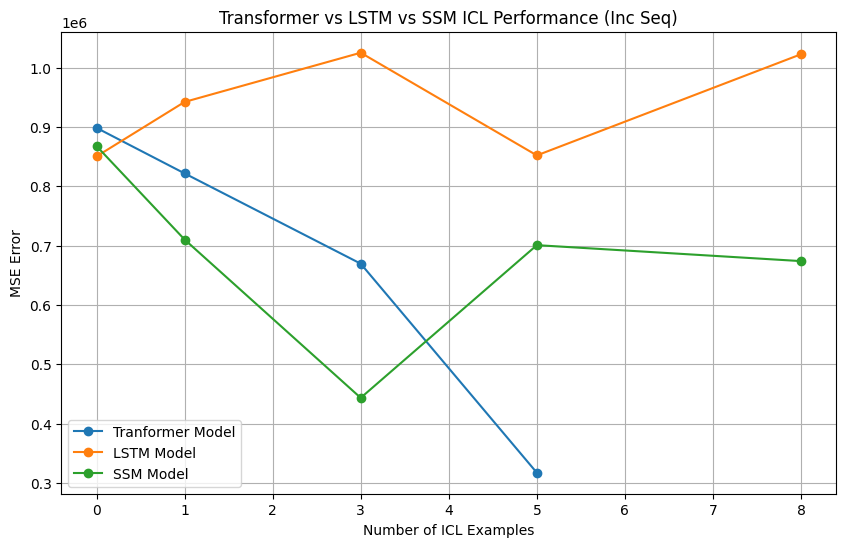

In [63]:
import matplotlib.pyplot as plt

x = list(transformer_results.keys())
y_mse = list(transformer_results.values())
y_lstm = list(lstm_results.values())
y_ssm = list(ssm_res.values())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_mse, marker='o', label="Tranformer Model")
plt.plot(x, y_lstm, marker='o', label="LSTM Model")
plt.plot(x, y_ssm, marker='o', label="SSM Model")

# Labels and formatting
plt.xlabel("Number of ICL Examples")
plt.ylabel("MSE Error")
plt.title("Transformer vs LSTM vs SSM ICL Performance (Inc Seq)")
plt.legend()
plt.grid(True)

plt.show()